In [1]:
import sys, os
import xsimlab as xs
import xarray as xa
import pandas as pd
import numpy as np
import sparse
import igraph as ig
import ipywidgets as widgets

sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab

In [2]:
from vmlab.models import fruit_model
from vmlab.processes import carbon_unit

model = fruit_model.drop_processes(['carbon_unit', 'light', 'photo', 'carbon', 'fruit_quality', 'fruit_growth', 'pheno_flower', 'pheno_leaf', 'gu_growth'])
model

<xsimlab.Model (6 processes, 9 inputs)>
params
    path                     [in]
    seed                     [in]
env
topo
    is_apical             [inout] ('GU',) 
    adjacency             [inout] ('GU', 'GU') 
    nb_leaves_gu          [inout] ('GU',) 
pheno_gu
inflo_growth
gu_burst
    burst_t_apical           [in]
    burst_t_lateral          [in]
    gu_bursted            [inout] ('GU',) 
    gu_bursted_is_apical  [inout] ('GU',) 

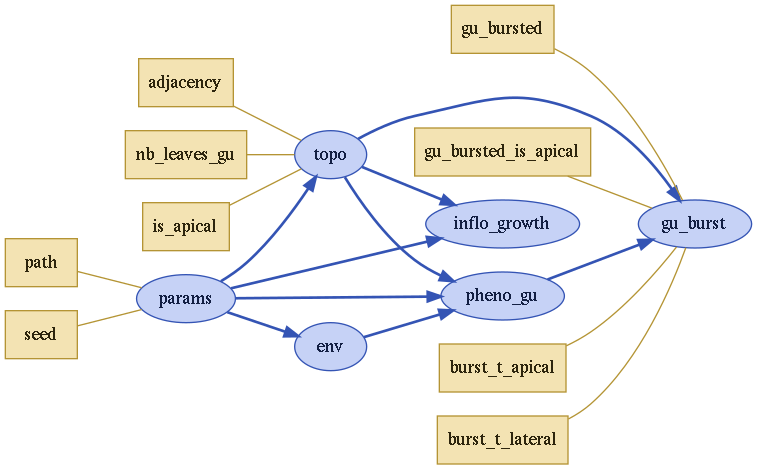

In [3]:
model.visualize(show_inputs=True, show_variables=False)

In [4]:
ds = vmlab.create_setup(
    model=model,
    clocks={
        'day': pd.date_range(start='2002-09-02', end='2003-03-28', freq="1d"),
        'week': pd.date_range(start='2002-09-02', end='2003-03-28', freq="1W")
    },
    master_clock='day',
    input_vars={
        'params': {
            'seed': 0,
            'path': '../share/setup/default.toml'
        },
        'gu_burst': {
            'burst_t_apical': 50,
            'burst_t_lateral': 100,
            'gu_bursted': [False, False, False, False, False, False, False],
            'gu_bursted_is_apical': [False, False, False, False, False, False, False]
        },
        'topo': {
            'adjacency': sparse.COO(np.array([
                    [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6]
                ]).transpose(), True, shape=(7, 7)),
            'is_apical': [False, False, False, True, False, False, False],
            'nb_leaves_gu': [0, 5, 10, 25, 50, 100, 150]
        }
    },
    output_vars = {
        'topo': {
            'is_apical': 'week',
            'adjacency': 'week',
            'nb_leaves_gu': 'week'
        },
        'pheno_gu': {
            'gu_growth_tts': 'week',
            'gu_stage': 'week'
        },
        'gu_burst': {
            'gu_bursted': 'week',
            'gu_bursted_is_apical': 'week'
        }
    }
)

In [5]:
ds

Format,coo
Data Type,bool
Shape,"(7, 7)"
nnz,6
Density,0.12244897959183673
Read-only,True
Size,102
Storage ratio,2.1


In [6]:
out = widgets.Output(layout=widgets.Layout(min_width='800px', min_height='800px'))
stage_color = {'A':'grey', 'B':'green', 'C':'yellow', 'D':'orange'}
@xs.runtime_hook('run_step')
def runtime_hook(model, context, state):
    if context['step'] % 7 == 0 or context['step'] == context['nsteps'] - 1:
        GU = state[('topo', 'GU')]
        adjacency = state[('topo', 'adjacency')]
        is_apical = state[('topo', 'is_apical')]
        gu_growth_tts = state[('pheno_gu', 'gu_growth_tts')]
        gu_stage = state[('pheno_gu', 'gu_stage')]
        g = ig.Graph.Adjacency(list(np.ones(adjacency.shape) * adjacency))
        l = g.layout_reingold_tilford(root=0)
        l.rotate(-90)
        style = {
            'vertex_size': 7,
            'vertex_color': [stage_color[s] for s in gu_stage],
            'vertex_label_size': 15,
            #'vertex_label': [int(t) for s,t in zip(gu_stage, gu_growth_tts)],
            'edge_arrow_size': 0,
            'edge_arrow_width': 1
        }
        with out:
            out.clear_output(wait=True)
            print(context['step'] + 1, '/' ,context['nsteps'], 'GU:', GU.shape[0])
            display(ig.plot(g, layout=l, bbox = (800, 500), margin=(20, 20, 20, 20), **style))
out

Output(layout=Layout(min_height='800px', min_width='800px'))

In [7]:
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[runtime_hook])

(1938,)
(1938,)


ValueError: conflicting sizes for dimension 'GU': length 1723 on 'gu_burst__gu_bursted' and length 1938 on 'GU'

In [ ]:
ds_out

In [ ]:
ds_out[['pheno_gu__gu_growth_tts']].isel({'GU': slice(0,10) }).plot.scatter(x='day', y='pheno_gu__gu_growth_tts', col='GU', col_wrap=3, size=5)

In [ ]:
ds_out.pheno_gu__gu_growth_tts[:,0].plot.line()

In [ ]:
ds_out[['pheno_gu__gu_growth_tts', 'pheno_gu__gu_stage', 'topo__is_apical']].to_dataframe()

In [ ]:
day = '2003-01-01'

In [ ]:
# TODO: figure out how to better handle nan in adj matrix i.e. nan in boolen xarrat dataarray
adjacency = ds_out.topo__adjacency.sel(dict(day=day)).data
cols = ~(adjacency == False).all(0)
cols[0] = True
adjacency = adjacency[:,cols]
adjacency = adjacency[~(adjacency == False).all(1),:]
adjacency_sqr = np.zeros((max(adjacency.shape), max(adjacency.shape)))
adjacency_sqr[0:adjacency.shape[0],0:adjacency.shape[1]] = adjacency

In [ ]:
g = ig.Graph.Adjacency(list(adjacency_sqr))
g

In [ ]:
pheno_gu__gu_stage = ds_out.pheno_gu__gu_stage.sel(dict(day=day))
topo__is_apical = ds_out.topo__is_apical.sel(dict(day=day))
topo__is_apical

In [ ]:
g.vs.set_attribute_values(values=pheno_gu__gu_stage.data, attrname='stage')
g.vs.set_attribute_values(values=topo__is_apical.data, attrname='is_apical')

In [ ]:
layout = g.layout_reingold_tilford(root=0)
layout.rotate(-180)
ig.plot(g, layout=layout, bbox=(800, 500), **{'vertex_label': g.vs['stage'], 'vertex_color': ['red' if is_apical else 'white' for is_apical in g.vs['is_apical']]})

In [ ]:
ds_out.topo__is_apical